In [ ]:
#!pip install albumentations==0.4.6

In [1]:
!pip install --quiet torch_lr_finder

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/PRIYE/CNN_model_repo.git

Cloning into 'CNN_model_repo'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 7.26 KiB | 7.26 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [5]:
import os
import sys
sys.path.insert(0,'/content/drive/MyDrive/ERAV2/Assignment11')
%cd /content/drive/MyDrive/ERAV2/Assignment11
%pwd

/content/drive/MyDrive/ERAV2/Assignment11


'/content/drive/MyDrive/ERAV2/Assignment11'

In [6]:
from CNN_model_repo.utils import (
   GradCAM, generate_gradcam, plot_gradcam, plot_performance, plot_data, get_misclassified_predictions

)
from CNN_model_repo.resnet import ResNet18

In [20]:
from main import (Albumentations_CIFAR10, cuda
                  , train_transforms, test_transforms
                  , train, test
                  )

In [8]:

print("CUDA Available?", cuda, 'Albumentations version', A.__version__)

CUDA Available? True Albumentations version 1.3.1


In [19]:
train = Albumentations_CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = Albumentations_CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])


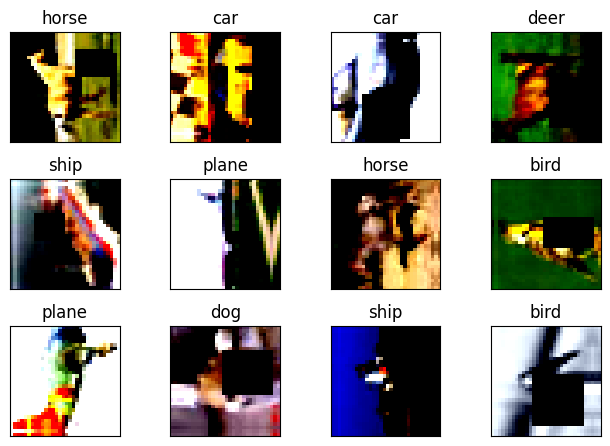

In [12]:
plot_data(train_loader)

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-04


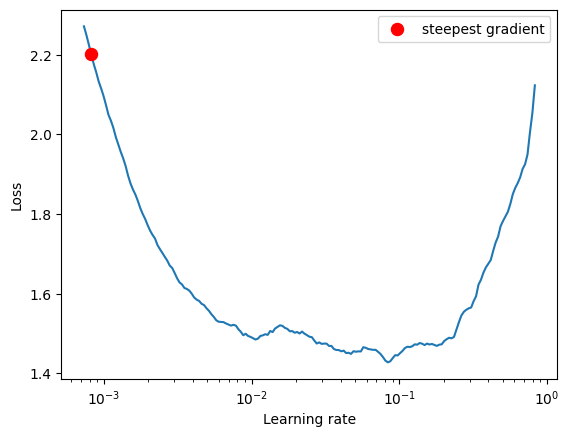

In [25]:
from torch_lr_finder import LRFinder
model = ResNet18().to(device)
#optimizer_lr = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
optimizer_lr = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer_lr, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [26]:
print(f"Lowest loss is at LR : {lr_finder.history['lr'][np.argmin(lr_finder.history['loss'])]}")
print(f"The LR which has sharpest downward slope is : {float( 8.22E-04):.15f}")

Lowest loss is at LR : 0.08351685313668646
The LR which has sharpest downward slope is : 0.000822000000000


In [31]:
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
ler_rate = 0.008
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = OneCycleLR(
        optimizer,
        max_lr= ler_rate,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=10,
        three_phase=False,
        final_div_factor=10,
        anneal_strategy='linear'
    )
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    scheduler.step()
    test_losses, test_acc = test(model, device, test_loader, criterion)

Epoch 1


Train: Loss=1.3231 Batch_id=97 Accuracy=41.97: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0026, Accuracy: 5146/10000 (51.46%)

Epoch 2


Train: Loss=1.0275 Batch_id=97 Accuracy=58.91: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.0020, Accuracy: 6344/10000 (63.44%)

Epoch 3


Train: Loss=0.8354 Batch_id=97 Accuracy=66.62: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test set: Average loss: 0.0018, Accuracy: 7027/10000 (70.27%)

Epoch 4


Train: Loss=0.7335 Batch_id=97 Accuracy=71.84: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0015, Accuracy: 7377/10000 (73.77%)

Epoch 5


Train: Loss=0.6225 Batch_id=97 Accuracy=75.78: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0017, Accuracy: 7248/10000 (72.48%)

Epoch 6


Train: Loss=0.5812 Batch_id=97 Accuracy=78.69: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0012, Accuracy: 7910/10000 (79.10%)

Epoch 7


Train: Loss=0.5163 Batch_id=97 Accuracy=80.39: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0011, Accuracy: 8097/10000 (80.97%)

Epoch 8


Train: Loss=0.6002 Batch_id=97 Accuracy=82.40: 100%|██████████| 98/98 [00:38<00:00,  2.51it/s]


Test set: Average loss: 0.0013, Accuracy: 7780/10000 (77.80%)

Epoch 9


Train: Loss=0.5130 Batch_id=97 Accuracy=83.62: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0011, Accuracy: 8136/10000 (81.36%)

Epoch 10


Train: Loss=0.4284 Batch_id=97 Accuracy=84.79: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0013, Accuracy: 7973/10000 (79.73%)

Epoch 11


Train: Loss=0.3933 Batch_id=97 Accuracy=86.01: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0010, Accuracy: 8396/10000 (83.96%)

Epoch 12


Train: Loss=0.3501 Batch_id=97 Accuracy=86.79: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0012, Accuracy: 8060/10000 (80.60%)

Epoch 13


Train: Loss=0.3873 Batch_id=97 Accuracy=87.66: 100%|██████████| 98/98 [00:38<00:00,  2.51it/s]


Test set: Average loss: 0.0011, Accuracy: 8220/10000 (82.20%)

Epoch 14


Train: Loss=0.3164 Batch_id=97 Accuracy=88.41: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0013, Accuracy: 7946/10000 (79.46%)

Epoch 15


Train: Loss=0.2850 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0008, Accuracy: 8625/10000 (86.25%)

Epoch 16


Train: Loss=0.2871 Batch_id=97 Accuracy=89.80: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0010, Accuracy: 8434/10000 (84.34%)

Epoch 17


Train: Loss=0.3109 Batch_id=97 Accuracy=89.96: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0009, Accuracy: 8532/10000 (85.32%)

Epoch 18


Train: Loss=0.2881 Batch_id=97 Accuracy=90.06: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0008, Accuracy: 8767/10000 (87.67%)

Epoch 19


Train: Loss=0.2439 Batch_id=97 Accuracy=90.87: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0013, Accuracy: 8060/10000 (80.60%)

Epoch 20


Train: Loss=0.3102 Batch_id=97 Accuracy=91.20: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test set: Average loss: 0.0009, Accuracy: 8585/10000 (85.85%)



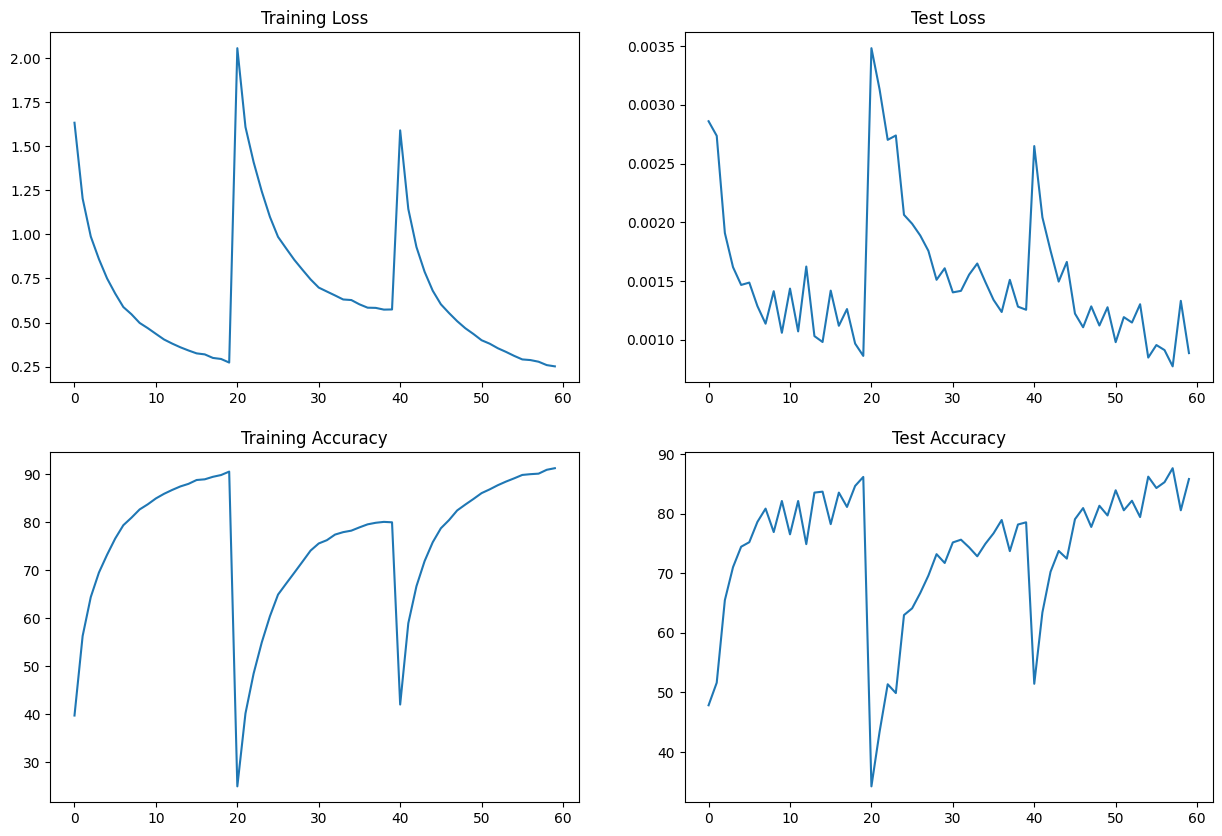

In [32]:
#train_losses_lst = [t_items.item() for t_items in train_losses]
plot_performance(train_losses, train_acc, test_losses, test_acc)

In [39]:
misclassified_dict = get_misclassified_predictions(model, test_loader, device )

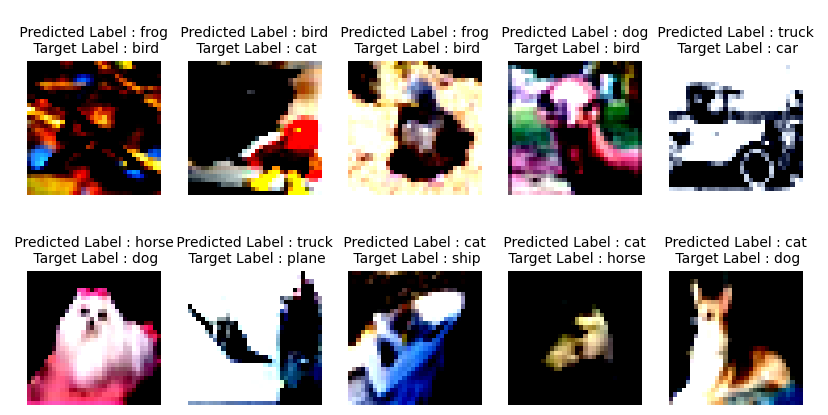

In [40]:
plot_misclassified_predictions(misclassified_dict, n=10)

In [76]:
target_layers = ["layer1","layer2","layer3","layer4"] # channel size 8X8
torch.autograd.set_detect_anomaly(True)
image_size = (3,32,32)

In [84]:
gcam_layers, probs, pred_class= generate_gradcam(misclassified_dict[:10], model, target_layers, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


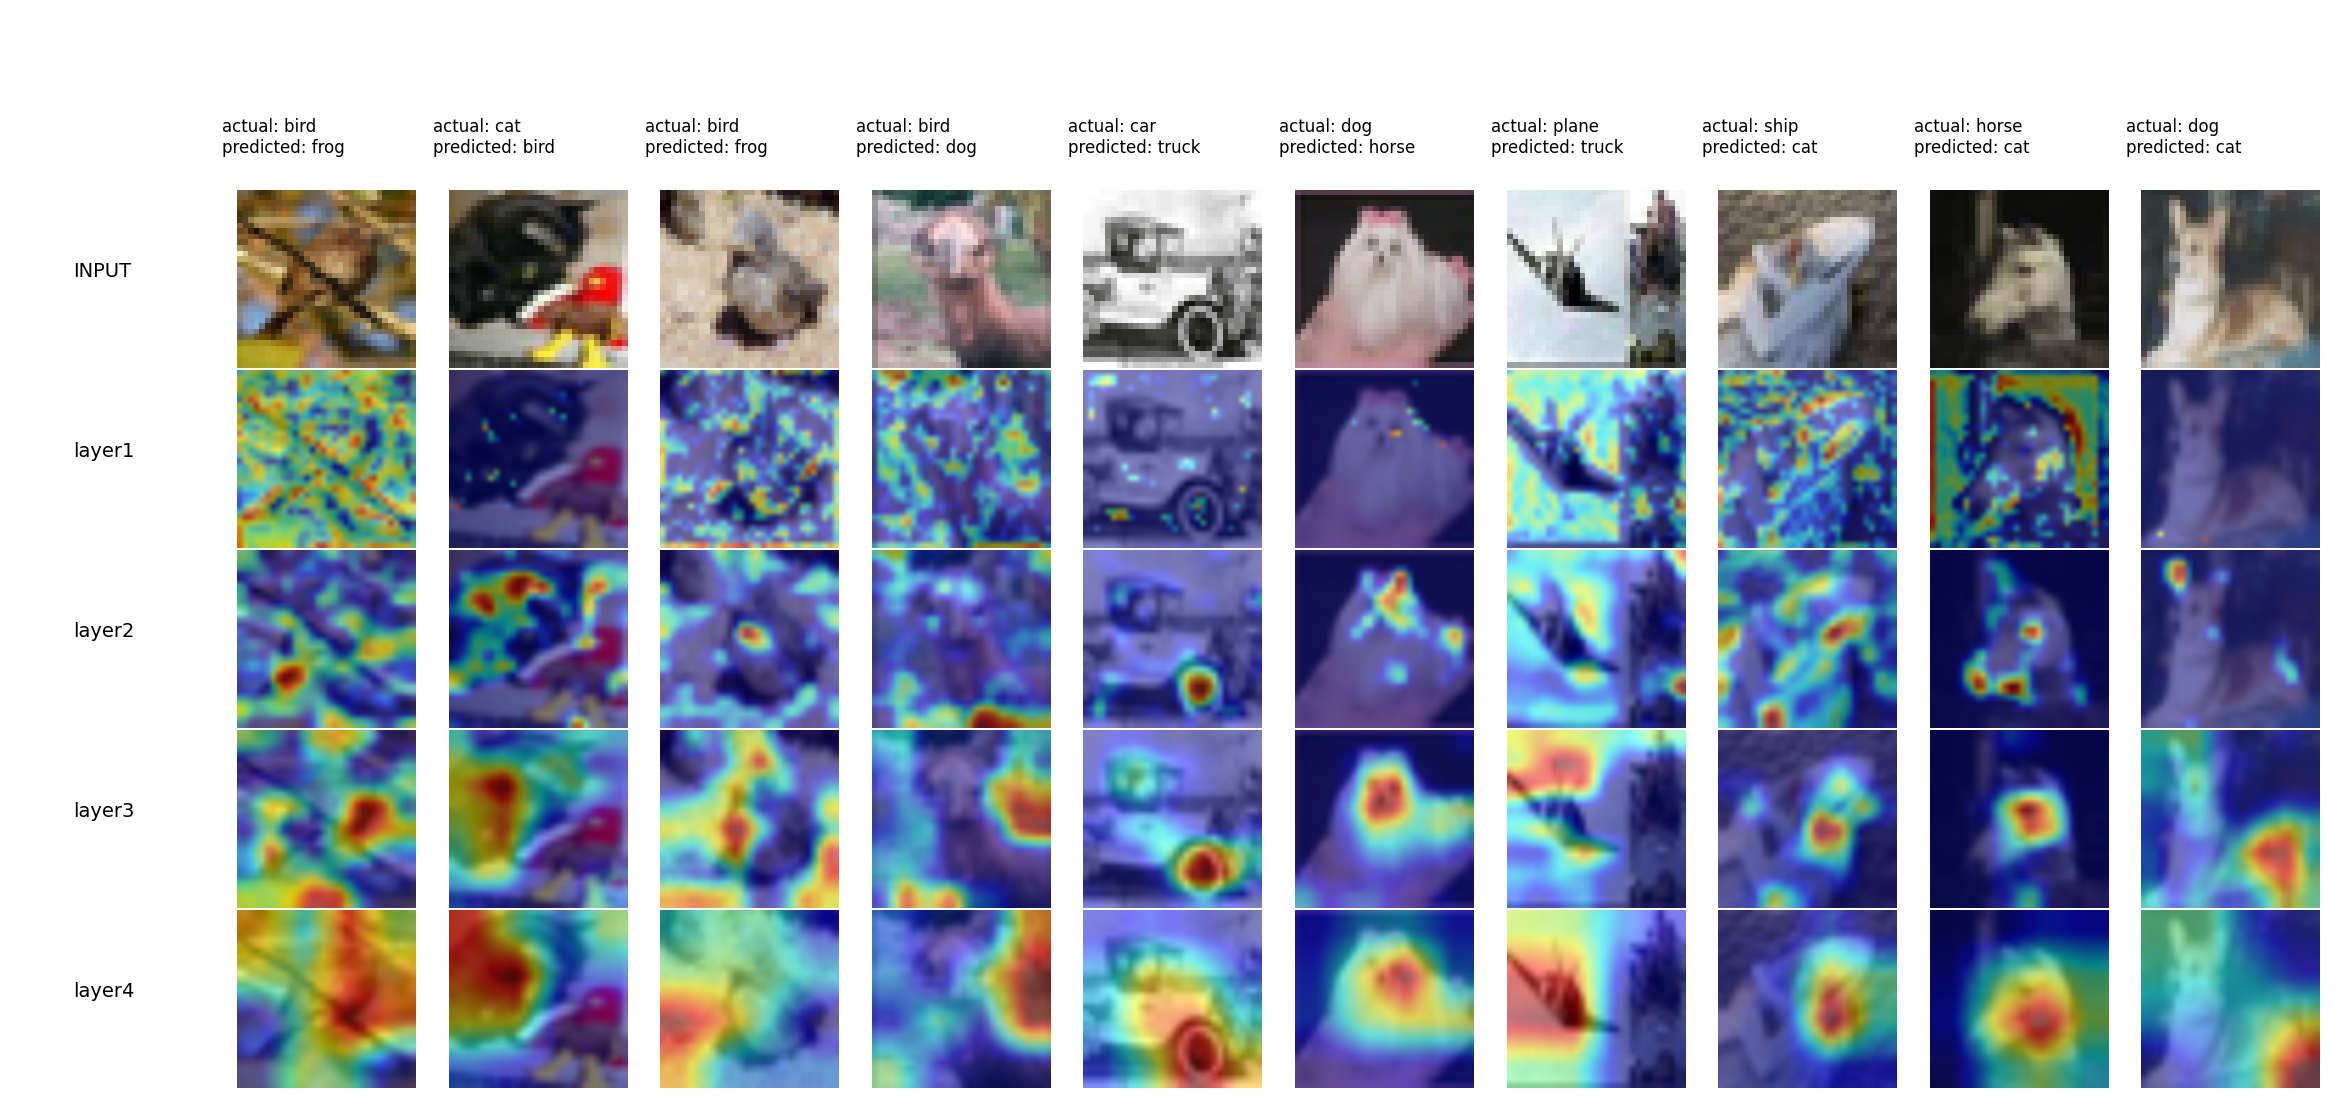

In [83]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_gradcam(gcam_layers, target_layers, classes, image_size ,pred_class, misclassified_dict[:10])